## 第5章: 係り受け解析
日本語Wikipediaの「人工知能」に関する記事からテキスト部分を抜き出したファイルがai.ja.zipに収録されている． この文章をCaboChaやKNP等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

### 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [1]:
class Morph:
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
        
    def __str__(self):
        return f"surface: {self.surface}, base: {self.base}, pos: {self.pos}, pos1: {self.pos1}"

In [2]:
import re

with open("ai.ja.txt.parsed", "r") as f:
    lines = f.read().splitlines()
    sentences_m = []
    s = []
    # sentences: [[s1], [s2], ...] or [[m11 m12 ...], [m21 m22 ...], ...]
    for line in lines:
        if re.search(r"^\*.*", line):
            # ignore line that start with '*'
            continue
            
        if line == "EOS":
            # end current sentence; start new sentence
            if len(s) != 0:
                sentences_m.append(s)
                s = []
        else:
            # append a morph object
            cols = re.split(r"\t|,", line)
            s.append(Morph(cols[0],cols[7],cols[1],cols[2]))
            if cols[0] == "。":
                sentences_m.append(s)
                s = []

# first element in the list is "人工知能" (title)
for sentence in sentences_m[:2]:
    for morph in sentence:
        print(morph)
    print("\n")

surface: 人工, base: 人工, pos: 名詞, pos1: 一般
surface: 知能, base: 知能, pos: 名詞, pos1: 一般


surface: 人工, base: 人工, pos: 名詞, pos1: 一般
surface: 知能, base: 知能, pos: 名詞, pos1: 一般
surface: （, base: （, pos: 記号, pos1: 括弧開
surface: じん, base: じん, pos: 名詞, pos1: 一般
surface: こうち, base: こうち, pos: 名詞, pos1: 一般
surface: のう, base: のう, pos: 助詞, pos1: 終助詞
surface: 、, base: 、, pos: 記号, pos1: 読点
surface: 、, base: 、, pos: 記号, pos1: 読点
surface: AI, base: *, pos: 名詞, pos1: 一般
surface: 〈, base: 〈, pos: 記号, pos1: 括弧開
surface: エーアイ, base: *, pos: 名詞, pos1: 固有名詞
surface: 〉, base: 〉, pos: 記号, pos1: 括弧閉
surface: ）, base: ）, pos: 記号, pos1: 括弧閉
surface: と, base: と, pos: 助詞, pos1: 格助詞
surface: は, base: は, pos: 助詞, pos1: 係助詞
surface: 、, base: 、, pos: 記号, pos1: 読点
surface: 「, base: 「, pos: 記号, pos1: 括弧開
surface: 『, base: 『, pos: 記号, pos1: 括弧開
surface: 計算, base: 計算, pos: 名詞, pos1: サ変接続
surface: （, base: （, pos: 記号, pos1: 括弧開
surface: ）, base: ）, pos: 記号, pos1: 括弧閉
surface: 』, base: 』, pos: 記号, pos1: 括弧閉
surface: という, base: という,

### 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [3]:
class Chunk:
    def __init__(self, index, morphs=[], dst=None, srcs=[]):
        self.index = index # added: 文節番号
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
    
    def __str__(self):
        morphs_rep = " ".join([m.surface for m in self.morphs])
        return f"morphs: {morphs_rep}, dst: {self.dst}, srcs: {self.srcs}"

In [4]:
sentences_c = []
s = []
srcs_dict = {0:[]}
morphs = []
chunk = Chunk(0)
reset_s = False # to reset variables for new sentence
reset_index = False # to reset variables for new paragraph
index = -1

# sentences_c: [[s1], [s2], ...] or [[c11 c12 ...], [c21 c22 ...], ...]
for line in lines: 
    if re.search(r"^\*.*", line):
        # append previously finished chunk to s
        # avoid doing this with the first line
        if index >= 0:
            if index in srcs_dict.keys():
                s.append( Chunk(index=index, morphs=morphs, dst=dst, srcs=srcs_dict[index]) )
            else:
                s.append( Chunk(index=index, morphs=morphs, dst=dst) )
            morphs = []
            
        # if to begin new sentence: append the current one and then reset variables
        if reset_s:
            if len(s)!=0:
                sentences_c.append(s)
            s = []
            reset_s = False
        
        if reset_index:
            srcs_dict = {0:[]}
            reset_index = False
                
        # collect index, dst value from "* [index] [dst]D ..."
        m = re.search(r"(?<=\*\s)(?P<index>(\d)+)\s(?P<dst>(-)?(\d)+).*", line)
        index = int(m.group("index"))
        dst = int(m.group("dst"))
        
        # update srcs_dict
        if dst in srcs_dict.keys():
            srcs_dict[dst].append(index)
        else:
            srcs_dict[dst] = [index]
            
    elif line == "EOS":
        reset_s = True
        reset_index = True # chunk index will be recounting from 0
        continue
        
    else:
        # add info to Chunk obj (morphs)
        cols = re.split(r"\t|,", line)
        morphs.append(Morph(cols[0],cols[7],cols[1],cols[2]))
        
        if cols[0] == "。":
            reset_s = True
            
# last line
if index in srcs_dict.keys():
    s.append( Chunk(index=index, morphs=morphs, dst=dst, srcs=srcs_dict[index]) )
else:
    s.append( Chunk(index=index, morphs=morphs, dst=dst) )
    morphs = []

if len(s)!=0:
    sentences_c.append(s)

# 確認
for sentence in sentences_c[:2]:
    for chunk in sentence:
        print(chunk)
    print("\n")

morphs: 人工 知能, dst: -1, srcs: []


morphs: 人工 知能, dst: 17, srcs: []
morphs: （ じん こうち のう 、 、, dst: 17, srcs: []
morphs: AI, dst: 3, srcs: []
morphs: 〈 エーアイ 〉 ） と は 、, dst: 17, srcs: [2]
morphs: 「 『 計算, dst: 5, srcs: []
morphs: （ ） 』 という, dst: 9, srcs: [4]
morphs: 概念 と, dst: 9, srcs: []
morphs: 『 コンピュータ, dst: 8, srcs: []
morphs: （ ） 』 という, dst: 9, srcs: [7]
morphs: 道具 を, dst: 10, srcs: [5, 6, 8]
morphs: 用い て, dst: 12, srcs: [9]
morphs: 『 知能 』 を, dst: 12, srcs: []
morphs: 研究 する, dst: 13, srcs: [10, 11]
morphs: 計算 機 科学, dst: 14, srcs: [12]
morphs: （ ） の, dst: 15, srcs: [13]
morphs: 一 分野 」 を, dst: 16, srcs: [14]
morphs: 指す, dst: 17, srcs: [15]
morphs: 語 。, dst: 34, srcs: [0, 1, 3, 16]




### 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [5]:
phrases_pair= []
phrases = dict() # phrase of each index
i_pair = [] # pairs of (src, dst) indices

for sentence in sentences_c:
    for chunk in sentence:
        i_pair.append((chunk.index, chunk.dst))
        # extract phrase
        p = "".join([morph.surface for morph in chunk.morphs if morph.pos!="記号"])
        phrases[chunk.index] = p
        
        if chunk.dst == -1:
            # append phrases_pair
            phrases[-1] = " " # dst=-1: phrases[-1] will be null string
            for i in i_pair:
                phrases_pair.append(phrases[i[0]]+"\t"+phrases[i[1]])
                
            # reset phrases and i_pair
            phrases = dict()
            i_pair = []

# first sentence
# 人工知能（じんこうちのう、、AI〈エーアイ〉）とは、「『計算（）』という概念と『コンピュータ（）』という道具を用いて『知能』を研究する計算機科学（）の一分野」を指す語。
for p in phrases_pair[:19]:
    print(p)

人工知能	 
人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語
語	研究分野とも


### 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [6]:
phrases_pair_NV = []
phrases = dict() # {index: (phrase, NP/VP/-)}
i_pair = [] # pairs of (src, dst) indices

for sentence in sentences_c:
    for chunk in sentence:
        i_pair.append((chunk.index, chunk.dst))
        # extract phrase
        p = "".join([morph.surface for morph in chunk.morphs if morph.pos!="記号"])
        pos_list = [morph.pos for morph in chunk.morphs]
        kind = "-"
        if "動詞" in pos_list:
            kind = "VP"
        elif "名詞" in pos_list:
            kind = "NP"
        # phrases.append((p, kind))
        phrases[chunk.index] = (p, kind)
        
        if chunk.dst == -1:
            # append phrases_pair
            phrases[-1] = (" ", "-")
            for i in i_pair:
                if phrases[i[0]][1]=="NP" and phrases[i[1]][1]=="VP":
                    phrases_pair_NV.append(phrases[i[0]][0]+"\t"+phrases[i[1]][0])
                
            # reset phrases and i_pair
            phrases = dict()
            i_pair = []
            
# first 2 sentences
# 人工知能（じんこうちのう、、AI〈エーアイ〉）とは、「『計算（）』という概念と『コンピュータ（）』という道具を用いて『知能』を研究する計算機科学（）の一分野」を指す語。
#「言語の理解や推論、問題解決などの知的行動を人間に代わってコンピューターに行わせる技術」、または、「計算機（コンピュータ）による知的な情報処理システムの設計や実現に関する研究分野」ともされる。
for p in phrases_pair_NV[:7]:
    print(p)

道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される


### 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい．

In [7]:
from graphviz import Digraph

def visualize(sentence):
    graph = Digraph(format="png", strict=True)
    phrases = dict() # phrase of each index
    i_pair = [] # pairs of (src, dst) indices
    threshold = sentence[0].index + len(sentence) 

    for chunk in sentence:
        i_pair.append((chunk.index, chunk.dst))
        # extract phrase
        p = "".join([morph.surface for morph in chunk.morphs if morph.pos!="記号"])
        phrases[chunk.index] = p
        graph.node(p)
        
    # append phrases_pair
    for i in i_pair:
        if i[1] > -1 and i[1] < threshold: # ignore when dst not in this sentence
            graph.edge(phrases[i[0]], phrases[i[1]])
            
    graph.render("images/out_44")
    return graph

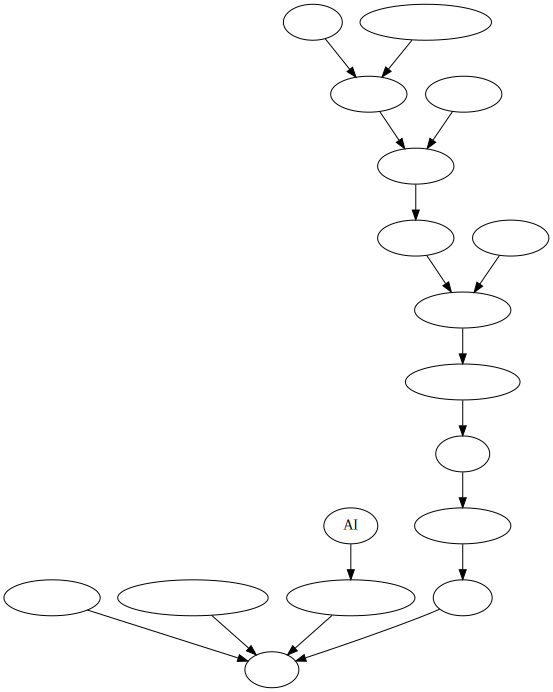

In [8]:
graph = visualize(sentences_c[1])
graph

### 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

- 動詞を含む文節において，最左の動詞の基本形を述語とする
- 述語に係る助詞を格とする
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

作り出す	で は を

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

- コーパス中で頻出する述語と格パターンの組み合わせ
- 「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [9]:
# 述語\t格
# 動詞\t助詞1 助詞2 ... 

with open("out_45.txt", "w") as f:
    for sentence in sentences_c:
        for chunk in sentence:
            # find all 動詞
            pos_list = [morph.pos for morph in chunk.morphs]
            if "動詞" in pos_list:
                V_i = pos_list.index("動詞") # only the first 動詞's index
                verb = chunk.morphs[V_i].base
                
                # find src of the 動詞
                # get 助詞 from all src
                src_chunks = [c for c in sentence if c.index in chunk.srcs]
                par_list = []
                for c in src_chunks:
                    pars = [m.base for m in c.morphs if m.pos=="助詞"]
                    if len(pars) > 0:
                        # par = "".join(pars) # if include 連結助詞：での、には、のに...
                        par = pars[-1] # only the last 助詞
                        par_list.append(par)
                if len(par_list) > 0:
                    line = "\t".join([verb, " ".join(set(sorted(par_list)))]) # 日本語の辞書順じゃないかも...
                    f.write(line+"\n")

In [10]:
!cat out_45.txt | head -n 10

用いる	を
する	を て
指す	を
代わる	に を
行う	に て
する	も
述べる	に は で
する	を で
する	を
する	を


In [11]:
!cat out_45.txt | sort | uniq -c | sort -nr | head -n 10

  52 する	を
  22 する	が
  21 する	と
  17 する	に
  14 する	は を
  11 よる	に
  10 する	に を
   9 する	を で
   8 行う	を
   8 する	は と


In [12]:
!cat out_45.txt | sort | uniq -c | sort -nr | grep "行う"

   8 行う	を
   1 行う	を まで
   1 行う	を で
   1 行う	を て
   1 行う	は を をめぐって
   1 行う	は を
   1 行う	は で が
   1 行う	は が
   1 行う	は
   1 行う	に を により
   1 行う	に を で
   1 行う	に を て
   1 行う	に を
   1 行う	に まで を
   1 行う	に て は が
   1 行う	に て
   1 行う	に
   1 行う	から


In [13]:
!cat out_45.txt | sort | uniq -c | sort -nr | grep "なる"

   4 なる	に は
   4 なる	と が
   2 なる	に
   2 なる	と
   1 異なる	も
   1 異なる	で が
   1 無くなる	は
   1 なる	も
   1 なる	は も
   1 なる	は にとって が
   1 なる	は で
   1 なる	は
   1 なる	に は で
   1 なる	に は が
   1 なる	に として て は
   1 なる	に が
   1 なる	など は と
   1 なる	と に で は が
   1 なる	と て は から が
   1 なる	で と から


In [14]:
!cat out_45.txt | sort | uniq -c | sort -nr | grep "与える"

   2 与える	に が
   1 与える	に を は


### 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

- 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
- 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

作り出す	で は を	会議で ジョンマッカーシーは 用語を

In [15]:
# 動詞\t助詞1 助詞2 ... \t 文節1 文節2 ...

with open("out_46.txt", "w") as f:
    for sentence in sentences_c:
        for chunk in sentence:
            # find all 動詞
            pos_list = [morph.pos for morph in chunk.morphs]
            if "動詞" in pos_list:
                V_i = pos_list.index("動詞") # only the first 動詞's index
                verb = chunk.morphs[V_i].base
                
                # find src of the 動詞
                # get 助詞 from all src
                src_chunks = [c for c in sentence if c.index in chunk.srcs]
                par_chunk = [] # store tuples of (助詞, 項)
                for c in src_chunks:
                    pars = [m.base for m in c.morphs if m.pos=="助詞"]
                    if len(pars) > 0:
                        i = [m.surface for m in c.morphs].index(pars[-1])
                        par_chunk.append( (pars[-1], "".join([morph.surface for morph in c.morphs[:i+1] if morph.pos!="記号"])) ) # (助詞, 項)
                if len(par_chunk) > 0:
                    par_chunk = sorted(par_chunk, key=lambda x: x[0]) # 日本語の辞書順じゃないかも...
                    line = "\t".join([verb, " ".join([x[0] for x in par_chunk]), " ".join([x[1] for x in par_chunk])])
                    f.write(line+"\n")

In [16]:
!cat out_46.txt | grep "作り出す"

作り出す	で は を	会議で ジョンマッカーシーは 用語を


In [17]:
!cat out_46.txt | head -n 10

用いる	を	道具を
する	て を	用いて 知能を
指す	を	一分野を
代わる	に を	人間に 知的行動を
行う	て に	代わって コンピューターに
する	も	研究分野とも
述べる	で に は	解説で 次のように 佐藤理史は
する	で を	コンピュータ上で 知的能力を
する	を	推論判断を
する	を	画像データを


### 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

- 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
- 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
- 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
- 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）
例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

学習を行う	に を	元に 経験を


In [18]:
# サ変接続名詞 = N+する できる名詞 (pos1="サ変接続")
# 「サ変接続名詞+を+動詞の基本形」\t 助詞1 助詞2 ... \t 文節1 文節2 ...
# 前提：「サ変接続名詞+を」が（例のように）複数ある場合は最右のものを選ぶ

with open("out_47.txt", "w") as f:
    for sentence in sentences_c:
        for chunk in sentence:
            # find all 動詞
            pos_list = [morph.pos for morph in chunk.morphs]
            if "動詞" in pos_list:
                V_i = pos_list.index("動詞") # only the first 動詞's index
                verb = chunk.morphs[V_i].base
                is_valid = False
                
                # find all src of the 動詞
                src_chunks = [c for c in sentence if c.index in chunk.srcs]
                par_chunk = []
                for c in src_chunks:
                    # check for「サ変接続名詞+を」/ keep only the last noun_wo
                    i_sa = [i for i in range(len(c.morphs)-1) if c.morphs[i].pos1=="サ変接続" and c.morphs[i+1].surface=="を"]
                    if len(i_sa) > 0: # should be == 1
                        is_valid = True
                        noun_wo = c.morphs[i_sa[0]].surface + c.morphs[i_sa[0]+1].surface # update the last noun_wo
                    
                    pars = [m.base for m in c.morphs if m.pos=="助詞"]   
                    if len(pars) > 0:
                        i = [m.surface for m in c.morphs].index(pars[-1])
                        par_chunk.append( (pars[-1], "".join([morph.surface for morph in c.morphs[:i+1] if morph.pos!="記号"])) )
                   
                # write into file if it is the valid verb (satisfy all cond.)
                if is_valid and len(par_chunk) > 0:
                    par_chunk = sorted(par_chunk, key=lambda x: x[0]) # 日本語の辞書順じゃないかも...
                    # exclude the noun_wo from par_chunk
                    for pc in par_chunk:
                        if pc[0]=="を" and noun_wo in pc[1]:
                            par_chunk.remove(pc)

                    line = "\t".join([noun_wo+verb, " ".join([x[0] for x in par_chunk]), " ".join([x[1] for x in par_chunk])])
                    f.write(line+"\n")

In [19]:
!cat out_47.txt | head -n 10

行動を代わる	に	人間に
判断をする		
処理を用いる		
記述をする	と	主体と
注目を集める	が	サポートベクターマシンが
学習を行う	に を	元に 経験を
流行を超える		
学習を繰り返す		
学習をする	に は を を通して	元に ACT-Rでは 推論ルールを 生成規則を通して
進化を見せる	て において は	加えて 生成技術において 敵対的生成ネットワークは


In [20]:
!cat out_47.txt | grep "学習を行う"

学習を行う	に を	元に 経験を


### 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

- 各文節は（表層形の）形態素列で表現する
- パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
```

KNPを係り受け解析に用いた場合，次のような出力が得られると思われる

```
ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した
```


In [21]:
# 根=文末 とする (!= chunk that dst=-1 (段落の末) )
with open("out_48.txt", "w") as f:
    for sentence in sentences_c:
        if len(sentence) == 1: # a title
            continue
        offset = sentence[0].index
        end = offset + len(sentence) - 1
        for chunk in sentence:
            if "名詞" in [m.pos for m in chunk.morphs]:
                # find route
                route = ["".join([m.surface for m in chunk.morphs if m.pos!="記号"])]
                dst = chunk.dst
                while dst!=-1 and dst<=end:
                    next_chunk = sentence[dst-offset]
                    route.append("".join([m.surface for m in next_chunk.morphs if m.pos!="記号"]))
                    dst = next_chunk.dst
                f.write(" -> ".join(route)+"\n")

In [22]:
!cat out_48.txt | grep "作り出した"

ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した


### 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

- 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
- 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

- 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
- 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

```
Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
```
KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．
```
Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを
```

In [58]:
with open("out_49.txt", "w") as f:
    for i_sentence in range(len(sentences_c)):
        sentence = sentences_c[i_sentence]
        # skip a non-sentence text (titles)
        if len(sentence) == 1:
            continue
            
        # prep some vars
        offset = sentence[0].index
        end = sentence[-1].index
        chunks_np = []  # all chunks with 名詞句
        for c in sentence:
            for m in c.morphs:
                if m.pos=="名詞":
                    chunks_np.append(c)
                    break
                    
        # for each 名詞句ペア
        for i in range(len(chunks_np)-1):
            for j in range(i+1, len(chunks_np)):
                # initialize
                route_i = ["X"+"".join([m.surface for m in chunks_np[i].morphs if m.pos!="記号" and m.pos!="名詞"])]
                dst_i = chunks_np[i].dst
                route_j = ["Y"+"".join([m.surface for m in chunks_np[j].morphs if m.pos!="記号" and m.pos!="名詞"])]
                dst_j = chunks_np[j].index
                
                # loop until finding a match
                while dst_i != dst_j:
                    if dst_i < dst_j:
                        if dst_i > end: # dst not in same sentence
                            next_chunk_i = [c for s in sentences_c[i_sentence + 1:] for c in s if c.index==dst_i][0]
                        else:
                            next_chunk_i = sentence[dst_i-offset]
                        route_i.append("".join([m.surface for m in next_chunk_i.morphs if m.pos!="記号"]))
                        dst_i = next_chunk_i.dst
                    else:
                        if dst_j > end:
                            next_chunk_j = [c for s in sentences_c[i_sentence+1:] for c in s if c.index==dst_j][0]
                        else:
                            next_chunk_j = sentence[dst_j-offset]
                            
                        if dst_j != chunks_np[j].index: # skip first dst_j (= chunks_np[j] itself)
                            route_j.append("".join([m.surface for m in next_chunk_j.morphs if m.pos!="記号"]))
                        dst_j = next_chunk_j.dst
                        
                # found a match
                # i meet j directly
                if dst_i == chunks_np[j].index:
                    line = " -> ".join(route_i+route_j)
                # i meet j through k
                else:
                    if dst_i > end:
                        chunk_k = [c for s in sentences_c[i_sentence + 1:] for c in s if c.index==dst_i][0]
                    else:
                        chunk_k = sentence[dst_i-offset]
                    phrase_k = "".join([m.surface for m in chunk_k.morphs if m.pos!="記号"])
                    line = " | ".join([" -> ".join(route_i), " -> ".join(route_j), phrase_k])
                    
                f.write(line+"\n")

In [61]:
!grep -m 1 -A 14 "作り出した" out_49.txt

Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
